## Review Project Analysis

Description:

Help a leading mobile brand understand the voice of the customer by analyzing the reviews of their product on Amazon

### Problem Statement:

A popular mobile phone brand, Lenovo has launched their budget smartphone in the Indian market. The client wants to understand the VOC (voice of the customer) on the product. This will be useful to not just evaluate the current product, but to also get some direction for developing the product pipeline. The client is particularly interested in the different aspects that customers care about. Product reviews by customers on a leading e-commerce site should provide a good view.

#### Steps to perform:

Discover the topics in the reviews and present it to business in a consumable format. Employ techniques in syntactic processing and topic modeling.

Perform specific cleanup, POS tagging, and restricting to relevant POS tags, then, perform topic modeling using LDA (Latent Dirichlet Allocation). Finally, give business-friendly names to the topics and make a table for business.

### Latent Dirichlet Allocation

In [2]:
import pandas as pd
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer

import string

import seaborn as sns
import matplotlib.pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
 
import warnings
warnings.filterwarnings('ignore')

### Content:

Dataset: 'K8 Reviews v0.2.csv'

Columns: [ 'sentiment' , 'review' ]


###### 1) Read the .csv file using Pandas. Take a look at the top few records.

In [3]:
df = pd.read_csv('K8 Reviews v0.2.csv')
df.head()

,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...
3,1,Good
4,0,The worst phone everThey have changed the last...


In [4]:
df.columns

Index(['sentiment', 'review'], dtype='object')

In [5]:
df.sentiment.value_counts()

0    7712
1    6963
Name: sentiment, dtype: int64

The sentiment against the review (4,5 star reviews are positive, 1,2 are negative)
* number of negative review: 7712
* number of positive review:  6963

###### 2) Normalize casings for the review text and extract the text into a list for easier manipulation.

In [6]:
review_text = list(df['review'].values)
review_text = [item.lower() for item in review_text]
review_text[0]

'good but need updates and improvements'

###### 3) Tokenize the reviews using NLTKs word_tokenize function.

In [7]:
from nltk.tokenize import word_tokenize
review_tokens = [word_tokenize(review) for review in review_text]
review_tokens[0]

['good', 'but', 'need', 'updates', 'and', 'improvements']

In [8]:
review_tokens[0]

['good', 'but', 'need', 'updates', 'and', 'improvements']

In [9]:
clean_review_tokens = []
# remove remaining tokens that are not alphabetic
for list_token in review_tokens:
    clean_review_tokens.append([word for word in list_token if word.isalpha()])

In [10]:
clean_reviews = [[token for token in clean_review_token if len(token) > 1] for clean_review_token in clean_review_tokens]

#docs = [[token for token in doc if len(token) > 1] for doc in docs]
len(clean_reviews)

14675

###### 4) Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.

In [11]:
all_nouns = []

review_pos = [nltk.pos_tag(tokens) for tokens in clean_reviews]
review0_nouns = [term for term,pos in review_pos[0] if pos.startswith("NN")]

##### 5) For the topic model, we should want to include only nouns.
* Find out all the POS tags that correspond to nouns.
* Limit the data to only terms with these tags.

In [12]:
for sent in review_pos:
    all_nouns.append([term for term,pos in sent if pos.startswith("NN")])

In [13]:
review0_nouns

['updates', 'improvements']

In [14]:
all_nouns[0:2]

[['updates', 'improvements'],
 ['battery',
  'hell',
  'backup',
  'hours',
  'internet',
  'uses',
  'lie',
  'amazon',
  'lenove',
  'battery',
  'charger',
  'hours',
  'don']]

In [15]:
print(len(review_text))
print(len(all_nouns))

14675
14675


##### 6)  Lemmatize.

* Different forms of the terms need to be treated as one.
* No need to provide POS tag to lemmatizer for now.

In [16]:
lemmatizer = WordNetLemmatizer()

lemmatized_nouns = []
for nouns in all_nouns:
    lemmatized_nouns.append([lemmatizer.lemmatize(item) for item in nouns])

In [17]:
lemmatized_nouns[0:2]

[['update', 'improvement'],
 ['battery',
  'hell',
  'backup',
  'hour',
  'internet',
  'us',
  'lie',
  'amazon',
  'lenove',
  'battery',
  'charger',
  'hour',
  'don']]

###### 7) Remove stopwords and punctuation (if there are any).



In [18]:
from nltk.corpus import stopwords
from string import punctuation

In [19]:
stop_nltk = stopwords.words("english")
stop_punct = list(punctuation)
stop_final = stop_nltk + stop_punct
print(len(stop_final))

text_clean = []
for term in lemmatized_nouns:
    text_clean.append([item for item in term if item not in stop_final])
    
text_clean[0:2]

211


[['update', 'improvement'],
 ['battery',
  'hell',
  'backup',
  'hour',
  'internet',
  'us',
  'lie',
  'amazon',
  'lenove',
  'battery',
  'charger',
  'hour']]

### Latent Dirichlet Allocation (LDA)

* LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.
* Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.
* LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial. It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution.

##### 8)  Create a topic model using LDA on the cleaned-up data with 12 topics

* Print out the top terms for each topic.
* What is the coherence of the model with the c_v metric?

In [20]:
import gensim
from gensim.models import CoherenceModel

from tqdm import tqdm_notebook  as tqdm

In [21]:
dictionary = gensim.corpora.Dictionary(text_clean)

dictionary.filter_extremes(no_below=15, no_above=0.5)
print(dictionary)

Dictionary(517 unique tokens: ['improvement', 'update', 'amazon', 'backup', 'battery']...)


In [22]:
# Bag-of-words representation of the documents.
bow_corpus = [dictionary.doc2bow(doc) for doc in text_clean]

print(bow_corpus[0])

[(0, 1), (1, 1)]


The doc2bow() function converts dictionary into a bag-of-words
* In each document vector is a series of tuples
* The tuples are (term ID, term frequency) pairs
* This includes terms that actually occur - terms that do not occur in a document will not appear in that document’s vector

In [23]:
# show the actual terms with the term frequency
[[(dictionary[id], freq) for id, freq in cp] for cp in bow_corpus[:1]]

[[('improvement', 1), ('update', 1)]]

### Hyperparameter Tuning for random_state

In [24]:
from tqdm import tqdm_notebook as tqdm

limit = 13
num_topics = 12
rand = list(np.arange(13,40,2))

b = 0.01
a = 0.61
for r in tqdm(rand):
    lm = gensim.models.LdaModel(corpus=bow_corpus, num_topics=num_topics, alpha='auto', eta='auto', random_state=r, id2word=dictionary, passes=10)
    cm = CoherenceModel(model=lm, texts=text_clean, dictionary=dictionary,coherence='c_v')
            
    print("{} - {} ".format(cm.get_coherence(),r))

  0%|          | 0/14 [00:00<?, ?it/s]

0.5393236674179007 - 13 
0.5316661030445747 - 15 
0.5125720811806537 - 17 
0.5202565462213121 - 19 
0.5517544942098908 - 21 
0.5318244191743492 - 23 
0.5184065953881257 - 25 
0.5240136417847616 - 27 
0.5438222672344666 - 29 
0.5366056452675256 - 31 
0.5173672311909299 - 33 
0.5330179113186869 - 35 
0.5325630849497399 - 37 
0.4955822903959948 - 39 


random_state with highest score: 21

### Hyperparameter Tuning for Alpha and Eta

In [25]:
from tqdm import tqdm_notebook as tqdm

limit = 13
alpha=list(np.arange(0.01,1,0.3))
beta=list(np.arange(0.01,1,0.3))
num_topics = 12
r=21

for b in tqdm(beta):
    for a in alpha:
        #lm = gensim.models.LdaModel(corpus=bow_corpus, num_topics=num_topics, alpha=a, eta=b, random_state=r, id2word=dictionary)
        lm = gensim.models.LdaModel(corpus=bow_corpus, num_topics=num_topics, alpha=a, eta=b, random_state=r, id2word=dictionary, passes=10)
        cm = CoherenceModel(model=lm, texts=text_clean, dictionary=dictionary,coherence='c_v')
        print("{} - {} - {} - {}".format(cm.get_coherence(),b,a,r))

  0%|          | 0/4 [00:00<?, ?it/s]

0.5586497962557168 - 0.01 - 0.01 - 21
0.4956775745205788 - 0.01 - 0.31 - 21
0.4737986082958378 - 0.01 - 0.61 - 21
0.5153770090442823 - 0.01 - 0.9099999999999999 - 21
0.5678200935379377 - 0.31 - 0.01 - 21
0.5080016418237573 - 0.31 - 0.31 - 21
0.47740102053037586 - 0.31 - 0.61 - 21
0.5216276305628544 - 0.31 - 0.9099999999999999 - 21
0.582619689515261 - 0.61 - 0.01 - 21
0.5088670263531173 - 0.61 - 0.31 - 21
0.4821469004865648 - 0.61 - 0.61 - 21
0.4917114090982179 - 0.61 - 0.9099999999999999 - 21
0.5753184078345135 - 0.9099999999999999 - 0.01 - 21
0.5071666660217321 - 0.9099999999999999 - 0.31 - 21
0.48751600835564535 - 0.9099999999999999 - 0.61 - 21
0.4852180214267223 - 0.9099999999999999 - 0.9099999999999999 - 21


Best value for Alpha and Eta: (b = 0.91, a = 0.61)
* Alpha = 0.01
* Eta = 0.61

### Building the LDA model using the Hyperparameters found for 12 topics

In [26]:
b = 0.61
a = 0.01
r = 21

model = gensim.models.LdaModel(corpus=bow_corpus, num_topics=num_topics, alpha=a, eta=b, random_state=r, id2word=dictionary, passes=10)

In [27]:
for idx, topic in model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.440*"problem" + 0.152*"heating" + 0.030*"super" + 0.029*"smartphone" + 0.023*"set" + 0.021*"pls" + 0.016*"model" + 0.012*"cell" + 0.012*"condition" + 0.010*"note"


Topic: 1 
Words: 0.231*"money" + 0.109*"waste" + 0.089*"value" + 0.057*"superb" + 0.042*"delivery" + 0.038*"worth" + 0.031*"ok" + 0.030*"buy" + 0.021*"star" + 0.021*"dont"


Topic: 2 
Words: 0.322*"camera" + 0.206*"quality" + 0.043*"speaker" + 0.031*"sound" + 0.024*"speed" + 0.019*"picture" + 0.019*"performance" + 0.017*"note" + 0.015*"image" + 0.014*"feature"


Topic: 3 
Words: 0.507*"mobile" + 0.115*"performance" + 0.044*"expectation" + 0.034*"excellent" + 0.019*"item" + 0.018*"plz" + 0.016*"feature" + 0.014*"purchase" + 0.013*"phn" + 0.012*"superb"


Topic: 4 
Words: 0.346*"battery" + 0.067*"backup" + 0.054*"hour" + 0.050*"day" + 0.039*"life" + 0.036*"charge" + 0.035*"issue" + 0.031*"time" + 0.026*"drain" + 0.025*"performance"


Topic: 5 
Words: 0.146*"price" + 0.101*"charger" + 0.078*"range" + 0.072*"

### Coherence of model with c_v metric: 

In [28]:
cm = CoherenceModel(model=model, texts=text_clean, dictionary=dictionary,coherence='c_v')
print("Coherence of model with c_v metric: {}".format(cm.get_coherence()))

Coherence of model with c_v metric: 0.582619689515261


##### 9) Analyze the topics through the business lens.

    Determine which of the topics can be combined.

* pyLDAvis result as shown in the visualization below. 
* The area of circle represents the importance of each topic over the entire corpus.
* The distance between the center of circles indicate the similarity between topics.
* For each topic, the histogram on the right side listed the top 30 most relevant terms.
* LDA extracted 12 main topics. 

From the visualization below we can see that only small overlap within 3 topics. Most topics are spread out evenly.
Therefore we can infer that the following topics can be combined together. Note the Topic number or Topic Id in the
visualization is assigned differently from my output. I will use the topic Id from Output [27] above.

   ##### 1 Topics 6 and 9 can be combined  -- Network/Service/Signal (Connectivity) Issues
   ##### 2 Topics 6 and 8 can be combined --  Phone and Usage Issues
   ##### 3 Topics 4 and 5 can be combined --  Battery Related Issues

In [29]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, bow_corpus, dictionary)
lda_viz

C:\Users\mglee\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.022336 -0.107560       1        1  12.474064
11     0.227138  0.030275       2        1  11.720112
8      0.125929 -0.233123       3        1  11.436588
6      0.006938 -0.182831       4        1  10.883912
7     -0.027035 -0.054837       5        1  10.744210
2      0.195729  0.210432       6        1   9.347773
10    -0.191062 -0.078975       7        1   8.687272
9     -0.093439 -0.033903       8        1   6.957829
5      0.138557  0.063696       9        1   5.899981
0     -0.151512  0.049491      10        1   4.770186
3     -0.058638  0.217587      11        1   3.654336
1     -0.194942  0.119748      12        1   3.423738, topic_info=           Term         Freq        Total Category  logprob  loglift
10        phone  6565.000000  6565.000000  Default  30.0000  30.0000
4       battery  2894.000000  2894.000000  Default  29.0000  29.0000
35      product  2047.000000  2047.000000  Default  28.0000  28.0000
41       camera  2962.000000  2962.000000  Default  27.0000  27.0000
11      problem  1411.000000  1411.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
104      please    35.456065   238.604841  Topic12  -4.1682   1.4679
149       brand    11.802869    90.884395  Topic12  -5.2682   1.3332
15        level     8.232480    46.612066  Topic12  -5.6284   1.6407
142  experience    11.066928   253.874468  Topic12  -5.3325   0.2416
31         time    13.627993   916.684326  Topic12  -5.1244  -0.8342

[528 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
484       1  0.039708  access
484       2  0.039708  access
484       3  0.039708  access
484       4  0.039708  access
484       5  0.714741  access
...     ...       ...     ...
18        8  0.012940    year
18        9  0.012940    year
18       10  0.012940    year
18       11  0.012940    year
18       12  0.012940    year

[4668 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 12, 9, 7, 8, 3, 11, 10, 6, 1, 4, 2])

##### Compute c_v coherence for various number of topics

In [30]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    # Set training parameters.
    b = 0.61
    a = 0.01
    # Use middle range random_state value
    r = 27
    # Make a index to word dictionary.
    #temp = dictionary[0]  # This is only to "load" the dictionary.
    #id2word = dictionary.id2token
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        #model = gensim.models.LdaModel(corpus=bow_corpus, num_topics=num_topics, alpha=a, eta=b,id2word=dictionary)
        lm = gensim.models.LdaModel(corpus=bow_corpus, num_topics=num_topics, alpha=a, eta=b, random_state=27, id2word=dictionary)
        model_list.append(lm)
        coherencemodel = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
 
    return model_list, coherence_values

##### Generate the list of LDA topics with each corresponding coherence_values

* model_list : List of LDA topic models
* coherence_values : Coherence values corresponding to the LDA model with respective number of topics

In [31]:
from tqdm import tqdm_notebook as tqdm
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=text_clean, start=2, limit=20, step=2)

C:\Users\mglee\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/9 [00:00<?, ?it/s]

##### 10) Create topic model using LDA with what you think is the optimal number of topics

* What is the coherence of the model?

     ##### made a plot showing:  number of topics vs coherence score.

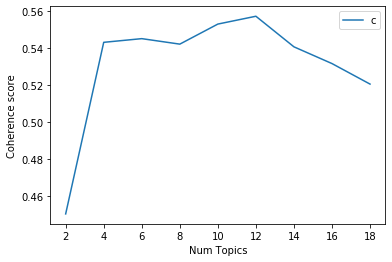

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

   * The plot shows the optimal number of topics.
   * Here we see 12 (Num Topics) have highest Coherence score.
   * 12 topics is optimal number of topics.

##### 11) The business should be able to interpret the topics.

* Name each of the identified topics.
* Create a table with the topic name and the top 10 terms in each to present to the  business.

In [33]:
topics=model.show_topics(formatted=False)

In [34]:
topics = sorted(topics)

In [35]:
top_terms=[]

top_id=[top for top,tl in topics]
terms =[tl for top,tl in topics]

for term in terms:
    top_terms.append([t for t,s in term])
#print(top_terms)

#### Give names to each of the identified topics

In [47]:
topic_names=['Problems','Value','Features','Positive','Battery Performance','Charging issues','Service issues','Other Issues','Amazon','Hardware Related']
topics = pd.DataFrame({'ID': top_id, 'Name': topic_names, 'top terms':top_terms})
topics.style.hide_index()

ID,Name,top terms
0,Problems,"['problem', 'heating', 'super', 'smartphone', 'set', 'pls', 'model', 'cell', 'condition', 'note']"
1,Value,"['money', 'waste', 'value', 'superb', 'delivery', 'worth', 'ok', 'buy', 'star', 'dont']"
2,Features,"['camera', 'quality', 'speaker', 'sound', 'speed', 'picture', 'performance', 'note', 'image', 'feature']"
3,Positive,"['mobile', 'performance', 'expectation', 'excellent', 'item', 'plz', 'feature', 'purchase', 'phn', 'superb']"
4,Battery Performance,"['battery', 'backup', 'hour', 'day', 'life', 'charge', 'issue', 'time', 'drain', 'performance']"
5,Charging issues,"['price', 'charger', 'range', 'heat', 'mode', 'turbo', 'camera', 'game', 'dolby', 'issue']"
6,Service issues,"['note', 'lenovo', 'phone', 'service', 'screen', 'day', 'glass', 'issue', 'display', 'time']"
8,Other Issues,"['phone', 'issue', 'price', 'month', 'feature', 'time', 'hang', 'use', 'lot', 'review']"
10,Amazon,"['product', 'amazon', 'return', 'service', 'customer', 'replacement', 'delivery', 'experience', 'time', 'policy']"
11,Hardware Related,"['camera', 'phone', 'feature', 'processor', 'everything', 'budget', 'ram', 'performance', 'clarity', 'handset']"


#### table with the topic name and the top 10 terms

In [48]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.022336 -0.107560       1        1  12.474064
11     0.227138  0.030275       2        1  11.720112
8      0.125929 -0.233123       3        1  11.436588
6      0.006938 -0.182831       4        1  10.883912
7     -0.027035 -0.054837       5        1  10.744210
2      0.195729  0.210432       6        1   9.347773
10    -0.191062 -0.078975       7        1   8.687272
9     -0.093439 -0.033903       8        1   6.957829
5      0.138557  0.063696       9        1   5.899981
0     -0.151512  0.049491      10        1   4.770186
3     -0.058638  0.217587      11        1   3.654336
1     -0.194942  0.119748      12        1   3.423738, topic_info=           Term         Freq        Total Category  logprob  loglift
10        phone  6565.000000  6565.000000  Default  30.0000  30.0000
4       battery  2894.000000  2894.000000  Default  29.0000  29.0000
35      product  2047.000000  2047.000000  Default  28.0000  28.0000
41       camera  2962.000000  2962.000000  Default  27.0000  27.0000
11      problem  1411.000000  1411.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
104      please    35.456065   238.604841  Topic12  -4.1682   1.4679
149       brand    11.802869    90.884395  Topic12  -5.2682   1.3332
15        level     8.232480    46.612066  Topic12  -5.6284   1.6407
142  experience    11.066928   253.874468  Topic12  -5.3325   0.2416
31         time    13.627993   916.684326  Topic12  -5.1244  -0.8342

[528 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
484       1  0.039708  access
484       2  0.039708  access
484       3  0.039708  access
484       4  0.039708  access
484       5  0.714741  access
...     ...       ...     ...
18        8  0.012940    year
18        9  0.012940    year
18       10  0.012940    year
18       11  0.012940    year
18       12  0.012940    year

[4668 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 12, 9, 7, 8, 3, 11, 10, 6, 1, 4, 2])